# Soil Mositure Prediction using LSTM
Data : Soil moisture remote sensing data, Forschungszentrum Julich (Germany, 2013)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping

In [18]:
df = pd.read_csv("updated_data.csv")

In [19]:
#Checking for missing values
df.isnull().sum()

time            0
latitude        0
longitude       0
clay_content    0
sand_content    0
silt_content    0
sm_aux          0
sm_tgt          0
dtype: int64

In [20]:
#Descriptive statistics
df.describe()

,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt
count,321584.000000,321584.000000,321584.00000,321584.000000,321584.000000,321584.000000,321584.000000
mean,50.840357,9.622973,20.88792,39.242963,39.894503,0.194109,0.411891
std,1.646484,3.789899,7.92268,21.846045,15.229785,0.088552,0.110530
min,48.125000,2.125000,4.00000,6.000000,8.000000,-0.038657,0.010000
25%,49.375000,6.625000,13.00000,22.000000,25.000000,0.126050,0.350000
50%,50.875000,9.875000,22.00000,32.000000,44.000000,0.178973,0.420000
75%,52.125000,12.875000,27.00000,61.000000,51.000000,0.257252,0.490000
max,54.875000,15.875000,46.00000,86.000000,72.000000,0.802321,0.600000


In [21]:
# Determine unique latitude-longitude pairs

unique_locations = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

In [22]:
# Number of unique locations in the dataset
unique_locations.shape[0]

1166

In [23]:
# Create a base map centered around Germany
m = folium.Map(location=[51.1657, 10.4515], zoom_start=5, tiles="OpenStreetMap", width=800, height=800)
m

In [24]:
# Add unique locations to the map
for idx, row in unique_locations.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

m

The data was supposed to cover only Germany, but it goes beyond Germany into Denmark, France, Beligium, and other neighbouring European countries.

In [25]:
# Create a unique identifier for each location
df['location_id'] = df.groupby(['latitude', 'longitude']).ngroup()

In [26]:
# Create a unique identifier for each location
df['location_id'] = df.groupby(['latitude', 'longitude']).ngroup()
df['location_id']

0         1163
1         1163
2         1163
3         1163
4         1163
          ... 
321579      55
321580      55
321581      55
321582      55
321583      55
Name: location_id, Length: 321584, dtype: int64

In [27]:
# Determine the start and end of the time series
start_date = df['time'].min()
end_date = df['time'].max()
print(f"The time series starts on {start_date} and ends on {end_date}.")

The time series starts on 2013-01-01 and ends on 2013-12-31.


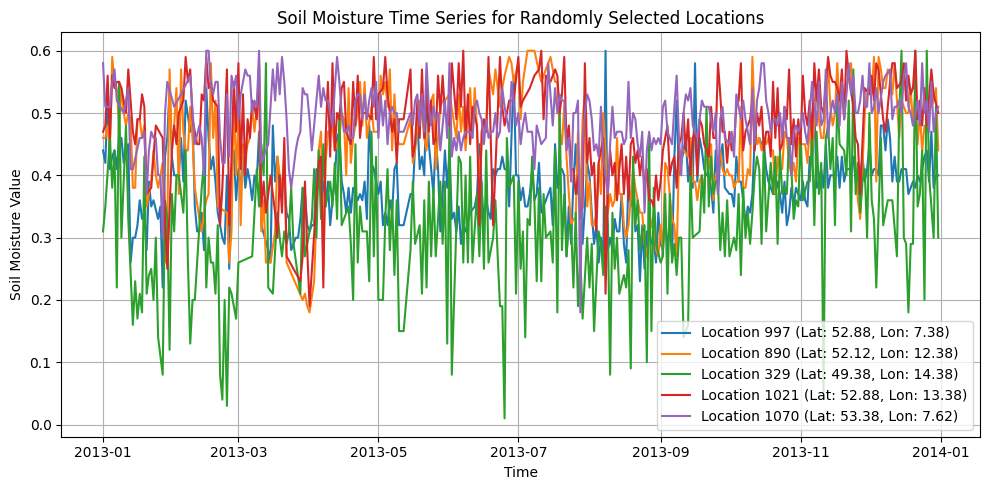

In [28]:
#EDA

# Randomly select five unique location IDs
random_locations = np.random.choice(df['location_id'].unique(), 5, replace=False)

# Plot time series data for the selected locations
plt.figure(figsize=(10, 5))
for location in random_locations:
    subset = df[df['location_id'] == location]
    lat = subset['latitude'].iloc[0]
    lon = subset['longitude'].iloc[0]
    plt.plot(pd.to_datetime(subset['time']), subset['sm_tgt'], label=f"Location {location} (Lat: {lat:.2f}, Lon: {lon:.2f})")

plt.title("Soil Moisture Time Series for Randomly Selected Locations")
plt.xlabel("Time")
plt.ylabel("Soil Moisture Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

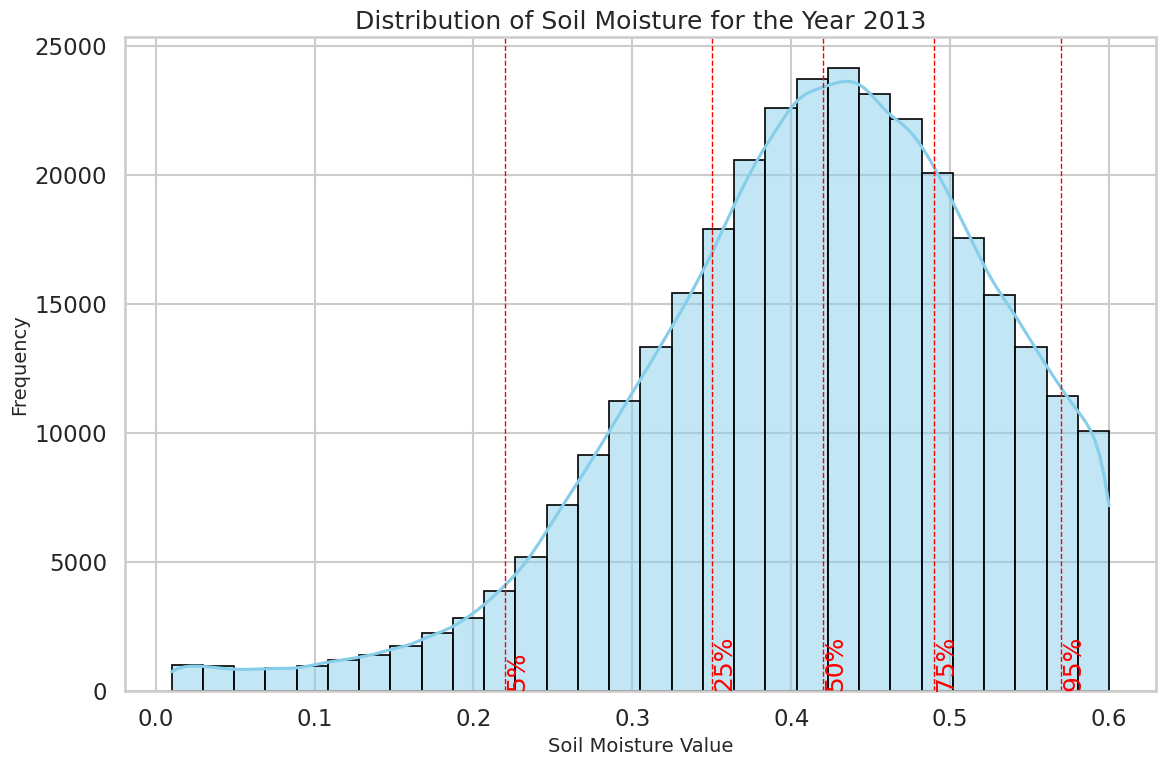

In [29]:
sns.set_style("whitegrid")
sns.set_context("talk")

# Create the distribution plot
plt.figure(figsize=(12, 8))
sns.histplot(df['sm_tgt'], kde=True, bins=30, color='skyblue', edgecolor='black', linewidth=1.2)

# Mark percentiles on the plot
percentiles = [5, 25, 50, 75, 95]
for percentile in percentiles:
    value = np.percentile(df['sm_tgt'], percentile)
    plt.axvline(value, color='red', linestyle='dashed', linewidth=1)
    plt.text(value, 5, f'{percentile}%', color='red', rotation=90, verticalalignment='bottom')

# Set the title and labels
plt.title("Distribution of Soil Moisture for the Year 2013", fontsize=18)
plt.xlabel("Soil Moisture Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.tight_layout()
plt.show()



*   Less than 5% of soil moisture values indicate very dry conditions
*   Less than 20% of the data points show soil moisture values that can be categorized as low, with a threshold of 0.25 differentiating between sufficiently irrigated and not sufficiently irrigated regions.
* Over 50% of the land has soil moisture values below 40% which raises concerns.



In [30]:
# Randomly sample 2000 data points from the dataframe
sample_df = df.sample(n=2000, random_state=42)

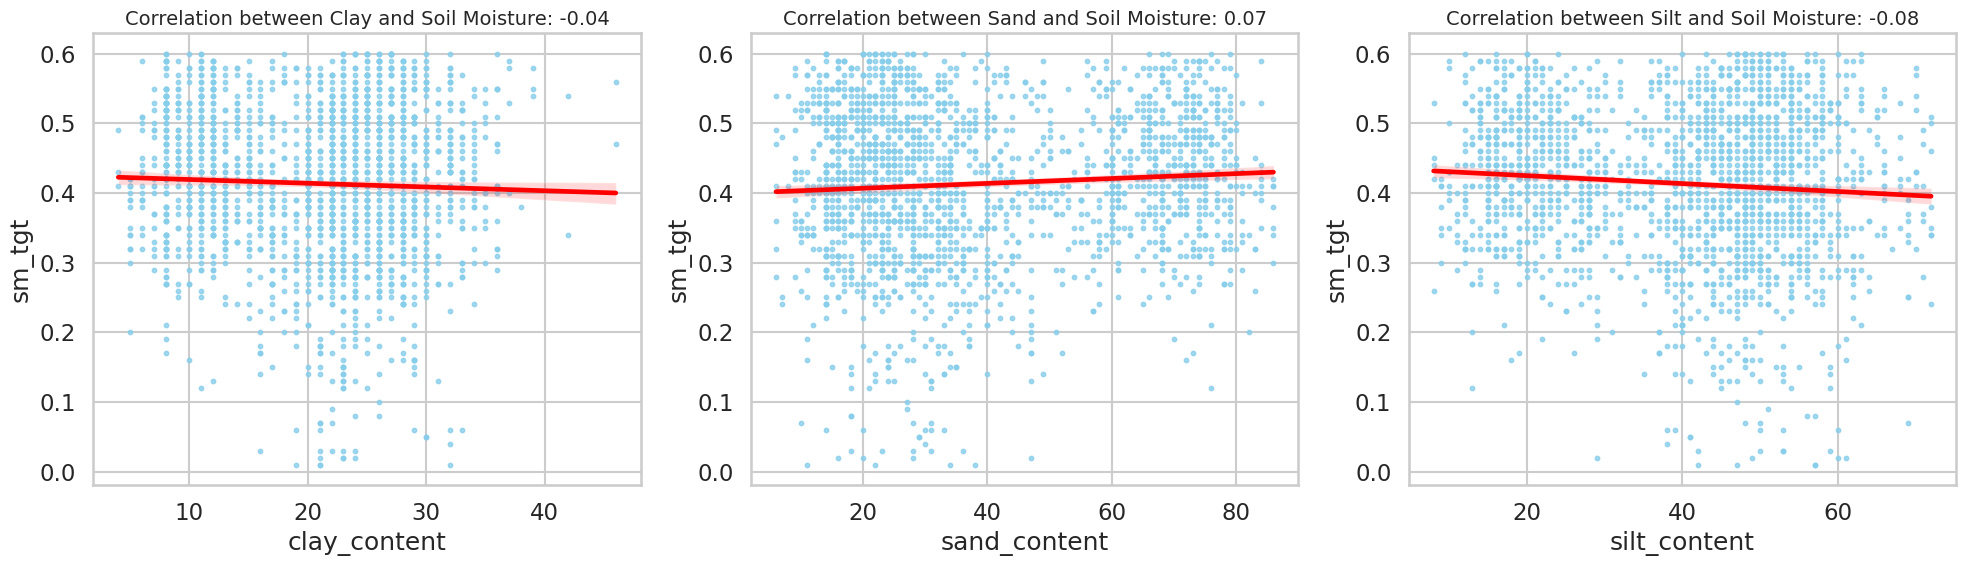

In [31]:
sns.set_style("whitegrid")
sns.set_context("talk")

# Initialize a figure with three subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# List of soil components
components = ['clay_content', 'sand_content', 'silt_content']

# Plot scatter plots for each component
for i, component in enumerate(components):
    sns.regplot(x=component, y='sm_tgt', data=sample_df, ax=axes[i], color='skyblue', scatter_kws={'s':10}, line_kws={'color':'red'})

    # Calculate correlation and annotate the plot with its value
    correlation = sample_df[component].corr(sample_df['sm_tgt'])
    axes[i].set_title(f"Correlation between {component.split('_')[0].capitalize()} and Soil Moisture: {correlation:.2f}", fontsize=14)

# Adjust layout for better display
plt.tight_layout()
plt.show()

* The correlation plots do not indicate any strong correlation between soil composition and soil moisture
* Some week trends are observed
 * Higher clay content is associated with lower soil moisture
 * Higher sand content seems to be associated with higher soil moisture
 * Increased silt content is associated with lower levels of soil moisture

* The data appears scattered without a clear directional trend, suggesting that soil moisture may not be predominantly influenced by soil type alone

* Given the predominance of automated irrigation systems in Europe, a lack of a clear trend might be a result of this



In [32]:
# Using the data from June as test data

# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Separate the data for June
june_data = df[df['time'].dt.month == 6]

# Remove June data from the main dataframe
df = df[df['time'].dt.month != 6]

june_data.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt,location_id
96,2013-06-01,54.875,9.125,5.0,86.0,9.0,0.132296,0.35,1163
97,2013-06-02,54.875,9.125,5.0,86.0,9.0,0.111909,0.31,1163
98,2013-06-03,54.875,9.125,5.0,86.0,9.0,0.099585,0.32,1163
99,2013-06-04,54.875,9.125,5.0,86.0,9.0,0.081596,0.32,1163
100,2013-06-05,54.875,9.125,5.0,86.0,9.0,0.098436,0.31,1163


In [33]:
# Create input sequencing
# Features to normalize
features_to_normalize = ['latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id','sm_tgt']

# Initialize scaler
scaler = MinMaxScaler()

# Apply normalization to the dataframe (both training and June data)
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
june_data[features_to_normalize] = scaler.transform(june_data[features_to_normalize])

# Reorder the columns to ensure 'sm_tgt' is the last column
ordered_columns = ['time', 'latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id', 'sm_tgt']
df = df[ordered_columns]
june_data = june_data[ordered_columns]

df.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,location_id,sm_tgt
0,2013-01-03,1.0,0.509091,0.02381,1.0,0.015625,0.585957,0.999141,0.881356
1,2013-01-05,1.0,0.509091,0.02381,1.0,0.015625,0.565721,0.999141,0.728814
2,2013-01-07,1.0,0.509091,0.02381,1.0,0.015625,0.537036,0.999141,0.694915
3,2013-01-08,1.0,0.509091,0.02381,1.0,0.015625,0.496316,0.999141,0.915254
4,2013-01-09,1.0,0.509091,0.02381,1.0,0.015625,0.463029,0.999141,0.762712


In [34]:
# Calculate the number of data points for each location in june_data
data_points_per_location = june_data.groupby('location_id').size()

# Identify locations with less than 15 days of data
locations_to_exclude = data_points_per_location[data_points_per_location < 15].index

# Filter out these locations from june_data
june_data = june_data[~june_data['location_id'].isin(locations_to_exclude)]

In [35]:
def create_sequences(data, seq_length):
    """
    Create input-output sequence pairs from the provided dataframe.
    """
    X, Y = [], []

    for location, group in data.groupby('location_id'):
        # Extract relevant features from the group
        features = group[features_to_normalize].drop(columns='sm_tgt').values
        targets = group['sm_tgt'].values

        # Create sequences
        for i in range(len(features) - seq_length):
            X.append(features[i:i+seq_length])
            Y.append(targets[i+seq_length])

    return X, Y

# Define the sequence length (30 days)
seq_length = 15

# Create sequences for training data
X, Y = create_sequences(df, seq_length)

# Convert lists to numpy arrays for easier handling later
X = np.array(X)
Y = np.array(Y)

X.shape, Y.shape

((277893, 15, 7), (277893,))

Epoch 1/10
1737/1737 [==============================] - 93s 52ms/step - loss: 0.0687 - val_loss: 0.0217
Epoch 2/10
1737/1737 [==============================] - 89s 51ms/step - loss: 0.0317 - val_loss: 0.0268
Epoch 3/10
1737/1737 [==============================] - 89s 51ms/step - loss: 0.0295 - val_loss: 0.0474
Epoch 4/10
1737/1737 [==============================] - 91s 52ms/step - loss: 0.0286 - val_loss: 0.0565
Epoch 4: early stopping


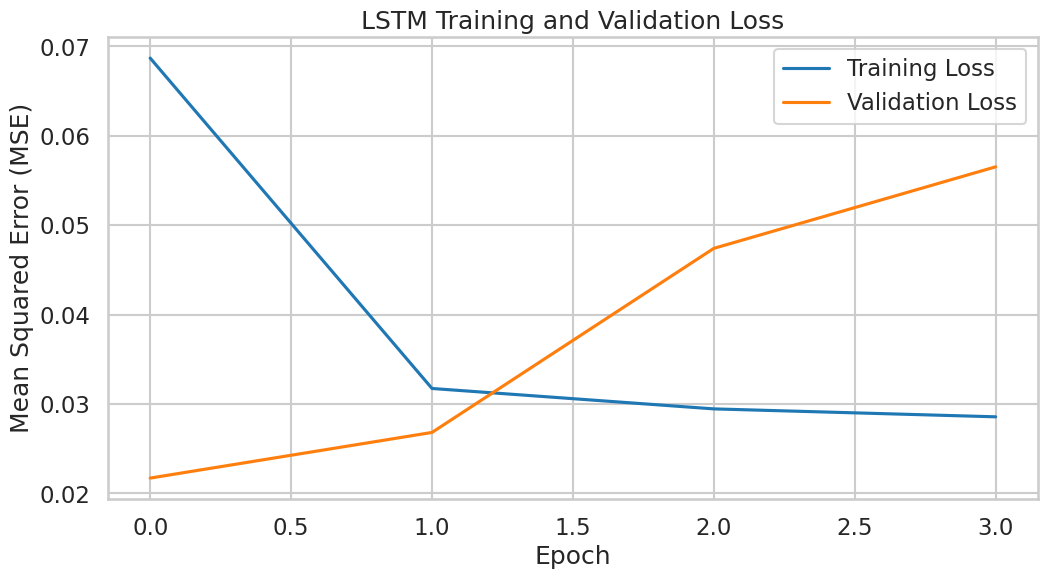

In [36]:
#LSTM Model

from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense
from keras.regularizers import l2

model = Sequential()
model.add(LSTM(75, activation='relu', input_shape=(X.shape[1], X.shape[2]), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), return_sequences=True))
model.add(LSTM(75, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# Dense output layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, Y, epochs=10, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stop])

# Plot the training and validation loss

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
X_june, Y_june_true = create_sequences(june_data, seq_length)
X_june = np.array(X_june);
Y_june_true = np.array(Y_june_true);
model.compile(optimizer='adam', loss='mse');
X_june.shape,Y_june_true.shape

((10158, 15, 7), (10158,))

In [38]:
predictions = model.predict(X_june,batch_size=128)


80/80 [==============================] - 2s 17ms/step


In [39]:
def reverse_scaling(data, scaler):
    """
    Reverse the scaling effect on data.
    """
    # Convert data to a 2D array if it's 1D
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)

    dummy = np.zeros((len(data), len(features_to_normalize)))

    # Set the last column of the dummy array to your data
    dummy[:, -1] = data.ravel()

    # Use inverse_transform to reverse the scaling
    unscaled = scaler.inverse_transform(dummy)

    # Return the last column (our actual unscaled data)
    return unscaled[:, -1]

In [40]:
# Reverse scaling for Y_june_true and predictions
Y_june_true_unscaled = reverse_scaling(Y_june_true, scaler)
predictions_unscaled = reverse_scaling(predictions, scaler)

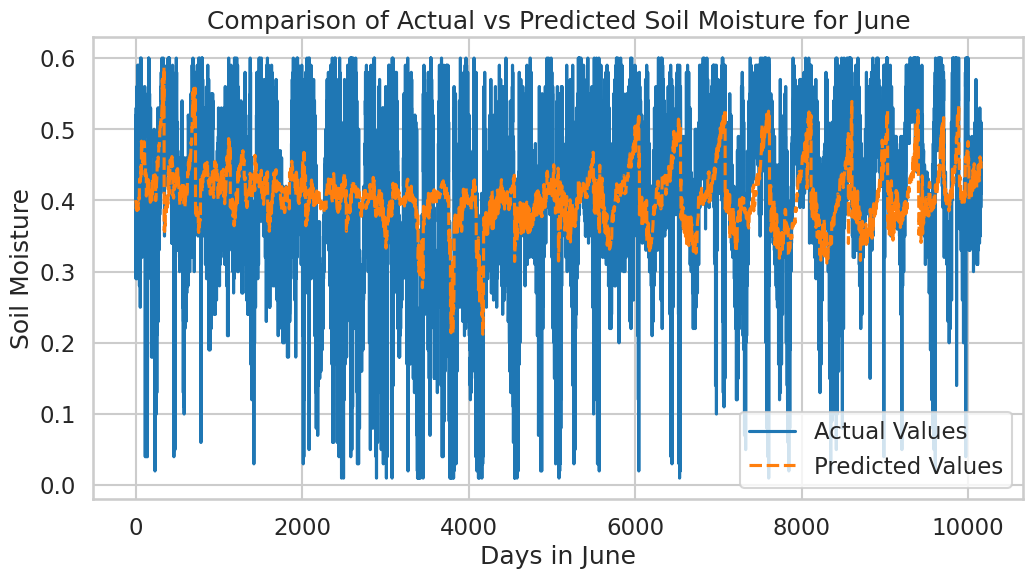

In [41]:
# Ensure both arrays are 1-dimensional
Y_june_true_unscaled = Y_june_true_unscaled.ravel()
predictions_unscaled = predictions_unscaled.ravel()

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Actual Values': Y_june_true_unscaled,
    'Predicted Values': predictions_unscaled
})

# Set Seaborn style
sns.set_style("whitegrid")

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot)
plt.title('Comparison of Actual vs Predicted Soil Moisture for June')
plt.ylabel('Soil Moisture')
plt.xlabel('Days in June')
plt.legend()
plt.show()

In [42]:
# Calculate MAE
mae = np.mean(np.abs(Y_june_true_unscaled - predictions_unscaled))
print(f"Mean Absolute Error for June Predictions: {mae}")

Mean Absolute Error for June Predictions: 0.08313002575934814


# Conclusions:
* The model is performing decently
* The model seems to capture the big picture of soil moisture data trend, although it misses some small details
